In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn_extra.cluster import KMedoids
from sklearn.feature_extraction.text import CountVectorizer
from data_parsing import load_trajectories

In [73]:
# session level edge data
#trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')
trajectories = load_trajectories('data/MITxPRO+AMxB+1T2018/edges')
#id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')


In [74]:
vectorizer = CountVectorizer(ngram_range=[2,2])
url_counts = vectorizer.fit_transform(list(trajectories.apply(lambda x : " ".join([str(url) for url in x]))))
len(vectorizer.get_feature_names())

31648

In [75]:
def get_medoid_clusters(k):
    kmedoids = KMedoids(n_clusters = k).fit(url_counts)
    kmedoids.labels_
    
    labels = pd.DataFrame(kmedoids.labels_)
    labels['index'] = trajectories.index
    labels['is exemplar'] = 0
    for exemplar in kmedoids.medoid_indices_:
        labels.iloc[exemplar, 2] = 1
    #labels.to_csv('MITxPRO+LASERxB1+1T2019_kmedoids {} clusters.csv'.format(k), header = ['cluster id', 'user id', 
                                                                                     #'is exemplar'], index = False)

    clusters = []
    cluster_id = []
    for i in range(k):
        clusters.append([])
        cluster_id.append([])
        
    for i, label in enumerate(kmedoids.labels_):
        clusters[label].append(trajectories.index[i])
        cluster_id[label].append(i)
        
    return cluster_id

In [76]:
variance_by_k = []
ks = list(range(2,7))
for k in ks:
    cluster_id = get_medoid_clusters(k)
    
    cluster_variances = []
    for i in range(k):
        cluster_variances.append(url_counts.todense()[cluster_id[i]].var())
    cluster_variances = np.array(cluster_variances)
    cluster_counts = np.array([len(x) for x in cluster_id])
    variance_by_k.append((cluster_variances*cluster_counts/len(trajectories)).sum())
    print(cluster_variances)

[0.03850127 0.01443559]
[0.03639269 0.01370657 0.04284131]
[0.02967598 0.01359317 0.032548   0.05966508]
[0.03010972 0.01350962 0.03318537 0.06303905 0.0297538 ]
[0.03118641 0.03379869 0.02421345 0.03184922 0.06737015 0.0107535 ]


In [55]:
temp = pd.read_csv('MITxPRO+AMxB+1T2018_kmedoids 7 clusters.csv')
temp[temp['is exemplar']==1]

,cluster id,user id,is exemplar
146,0,15886017,1
213,3,18386609,1
412,2,18608901,1
448,1,18663578,1
488,4,18776893,1
533,6,18863414,1
741,5,18955579,1


Text(0.5, 1.0, 'Additive Manufacturing for Innovative Design and Production (AM course)')

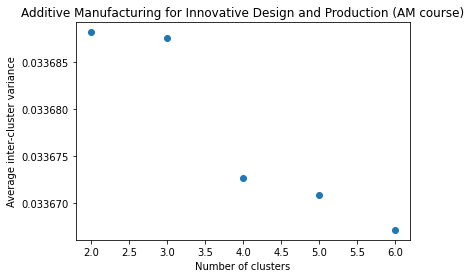

In [77]:
plt.scatter(ks, variance_by_k)
plt.xlabel('Number of clusters')
plt.ylabel('Average inter-cluster variance')
plt.title('Additive Manufacturing for Innovative Design and Production (AM course)')

In [47]:
#status = id_and_performance[id_and_performance['certGrp']== 'Certified (< 65% Grade)']
cluster_df = pd.read_csv('MITxPRO+AMxB+1T2018_kmedoids 4 clusters.csv')
performance_df = pd.merge(cluster_df, id_and_performance, left_on='user id', right_on='id')
performance_df['cluster id'] = pd.Categorical(performance_df['cluster id'])
performance_table = performance_df.groupby(['cluster id','certGrp'],
                                           as_index=False, observed=False).count()[['cluster id', 'certGrp', 'id']]
performance_table.columns = ['cluster id', 'certificate status', 'count']
performance_table

,cluster id,certificate status,count
0,0,Certified (< 70% Grade),355
1,0,Not certified (> 70% Grade),34
2,1,Certified (< 70% Grade),61
3,1,Not certified (> 70% Grade),111
4,2,Certified (< 70% Grade),134
5,2,Not certified (> 70% Grade),35
6,3,Certified (< 70% Grade),159
7,3,Not certified (> 70% Grade),41


In [10]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

,from,to,stds,weight,dis,sl
0,001339db8ced4cf78829ebe8b145449d,001339db8ced4cf78829ebe8b145449d,179,1096,0,1
1,001339db8ced4cf78829ebe8b145449d,452745e0366e42ae81561bfddebcc6c3,177,179,1,0
2,001339db8ced4cf78829ebe8b145449d,4660ff2089114e8db82ceb26a4f329e3,2,2,2,0
3,001339db8ced4cf78829ebe8b145449d,901e92500aea43c79f19f1b279050668,4,4,-1,0
4,00ae5f0c51874a73a41ebea838d95682,00ae5f0c51874a73a41ebea838d95682,119,383,0,1
